In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df_data = pd.read_csv('train.csv')

In [45]:
# 类别变量重新编码
# 数值变量，用0填充缺失值
sparse_feature_list = ["Pclass", "Sex", "Cabin", "Embarked"]
dense_feature_list = ["Age", "SibSp", "Parch", "Fare"]


sparse_feature_reindex_dict = {}
for i in sparse_feature_list:
    cur_sparse_feature_list = df_data[i].unique()
    
    sparse_feature_reindex_dict[i] = dict(zip(cur_sparse_feature_list, \
        range(1, len(cur_sparse_feature_list)+1)
                                     )
                                 )
    
    df_data[i] = df_data[i].map(sparse_feature_reindex_dict[i])


for j in dense_feature_list:
    df_data[j] = df_data[j].fillna(0)

In [46]:
# 分割数据集
data = df_data[sparse_feature_list + dense_feature_list]
label = df_data["Survived"].values

xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size=0.2, random_state=2020)

In [47]:
xtrain_data = {"Pclass": np.array(xtrain["Pclass"]), \
              "Sex": np.array(xtrain["Sex"]), \
              "Cabin": np.array(xtrain["Cabin"]), \
              "Embarked": np.array(xtrain["Embarked"]), \
              "Age": np.array(xtrain["Age"]), \
              "SibSp": np.array(xtrain["SibSp"]), \
              "Parch": np.array(xtrain["Parch"]), \
              "Fare": np.array(xtrain["Fare"])}

In [48]:
xtest_data = {"Pclass": np.array(xtest["Pclass"]), \
              "Sex": np.array(xtest["Sex"]), \
              "Cabin": np.array(xtest["Cabin"]), \
              "Embarked": np.array(xtest["Embarked"]), \
              "Age": np.array(xtest["Age"]), \
              "SibSp": np.array(xtest["SibSp"]), \
              "Parch": np.array(xtest["Parch"]), \
              "Fare": np.array(xtest["Fare"])}

In [49]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, \
    Dot, Flatten, Concatenate, Dense, Layer

from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Zeros, glorot_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [50]:
def input_embedding_layer(
    shape=1, \
    name=None, \
    vocabulary_size=1, \
    embedding_dim=1):
    
    input_layer = Input(shape=[shape, ], name=name)
    embedding_layer = Embedding(vocabulary_size, embedding_dim)(input_layer)
    
    return input_layer, embedding_layer

In [51]:
class Linear(Layer):

    def __init__(self, l2_reg=0.0, mode=2, use_bias=True, **kwargs):

        self.l2_reg = l2_reg
        if mode not in [0, 1, 2]:
            raise ValueError("mode must be 0, 1 or 2")
        self.mode = mode
        self.use_bias = use_bias
        super(Linear, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.use_bias:
            self.bias = self.add_weight(name='linear_bias',
                                        shape=(1,),
                                        initializer=tf.keras.initializers.Zeros(),
                                        trainable=True)
            
        if self.mode == 1:
            self.kernel = self.add_weight(
                'linear_kernel',
                shape=[int(input_shape[-1]), 1],
                initializer=tf.keras.initializers.glorot_normal(),
                regularizer=tf.keras.regularizers.l2(self.l2_reg),
                trainable=True)
            
        elif self.mode == 2 :
            self.kernel = self.add_weight(
                'linear_kernel',
                shape=[int(input_shape[1][-1]), 1],
                initializer=tf.keras.initializers.glorot_normal(),
                regularizer=tf.keras.regularizers.l2(self.l2_reg),
                trainable=True)

        super(Linear, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if self.mode == 0:
            sparse_input = inputs
            linear_logit = reduce_sum(sparse_input, axis=-1, keepdims=True)
        elif self.mode == 1:
            dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = fc
        else:
            sparse_input, dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = tf.reduce_sum(sparse_input, axis=-1, keepdims=False) + fc
        if self.use_bias:
            linear_logit += self.bias

        return linear_logit

    def compute_output_shape(self, input_shape):
        return (None, 1)

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):
        config = {'mode': self.mode, 'l2_reg': self.l2_reg,'use_bias':self.use_bias}
        base_config = super(Linear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [52]:
class BiInteractionPooling(Layer):
    """Bi-Interaction Layer used in Neural FM,compress the
     pairwise element-wise product of features into one single vector.

      Input shape
        - A 3D tensor with shape:``(batch_size,field_size,embedding_size)``.

      Output shape
        - 3D tensor with shape: ``(batch_size,1,embedding_size)``.

      References
        - [He X, Chua T S. Neural factorization machines for sparse predictive analytics[C]//Proceedings of the 40th International ACM SIGIR conference on Research and Development in Information Retrieval. ACM, 2017: 355-364.](http://arxiv.org/abs/1708.05027)
    """

    def __init__(self, **kwargs):
        super(BiInteractionPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))

        super(BiInteractionPooling, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))

        concated_embeds_value = inputs
        square_of_sum = tf.square(tf.reduce_sum(concated_embeds_value, axis=1, keepdims=True))
        sum_of_square = tf.reduce_sum(concated_embeds_value * concated_embeds_value, axis=1, keepdims=True)
        cross_term = 0.5 * (square_of_sum - sum_of_square)

        return cross_term

    def compute_output_shape(self, input_shape):
        return (None, 1, input_shape[-1])

In [53]:
class DNN(Layer):
    """The Multi Layer Percetron

      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.

      Arguments
        - **hidden_units**:list of positive integer, the layer number and units in each layer.

        - **activation**: Activation function to use.

        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix.

        - **dropout_rate**: float in [0,1). Fraction of the units to dropout.

        - **use_bn**: bool. Whether use BatchNormalization before activation or not.

        - **seed**: A Python integer to use as random seed.
    """

    def __init__(self, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.seed = seed
        self.l2_reg = l2_reg
        self.use_bn = use_bn
        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):
        # if len(self.hidden_units) == 0:
        #     raise ValueError("hidden_units is empty")
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(hidden_units[i], hidden_units[i + 1]),
                                        initializer=glorot_normal(seed=self.seed),
                                        regularizer=l2(self.l2_reg),
                                        trainable=True) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=Zeros(),
                                     trainable=True) for i in range(len(self.hidden_units))]
        if self.use_bn:
            self.bn_layers = [tf.keras.layers.BatchNormalization() for _ in range(len(self.hidden_units))]

        self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate, seed=self.seed + i) for i in
                               range(len(self.hidden_units))]

        self.activation_layers = [tf.keras.layers.Activation(self.activation) \
                                  for _ in range(len(self.hidden_units))]
        
        super(DNN, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs

        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(
                deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
            # fc = Dense(self.hidden_size[i], activation=None, \
            #           kernel_initializer=glorot_normal(seed=self.seed), \
            #           kernel_regularizer=l2(self.l2_reg))(deep_input)
            if self.use_bn:
                fc = self.bn_layers[i](fc, training=training)

            fc = self.activation_layers[i](fc)
            fc = self.dropout_layers[i](fc, training=training)
            
            deep_input = fc

        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1],)
        else:
            shape = input_shape

        return tuple(shape)

    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,
                  'l2_reg': self.l2_reg, 'use_bn': self.use_bn, 'dropout_rate': self.dropout_rate, 'seed': self.seed}
        base_config = super(DNN, self).get_config()
        
        return dict(list(base_config.items()) + list(config.items()))
    

In [54]:
class PredictionLayer(Layer):
    """
      Arguments
         - **task**: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss

         - **use_bias**: bool.Whether add bias term or not.
    """

    def __init__(self, task='binary', use_bias=True, **kwargs):
        if task not in ["binary", "multiclass", "regression"]:
            raise ValueError("task must be binary, multiclass or regression")
        self.task = task
        self.use_bias = use_bias
        super(PredictionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.use_bias:
            self.global_bias = self.add_weight(
                shape=(1,), initializer=Zeros(), name="global_bias")

        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        if self.use_bias:
            x = tf.nn.bias_add(x, self.global_bias, data_format='NHWC')
        if self.task == "binary":
            x = tf.sigmoid(x)

        output = tf.reshape(x, (-1, 1))

        return output

    def compute_output_shape(self, input_shape):
        return (None, 1)

    def get_config(self, ):
        config = {'task': self.task, 'use_bias': self.use_bias}
        base_config = super(PredictionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [55]:
def nfm(sparse_feature_list, \
        sparse_feature_reindex_dict, \
        dense_feature_list, \
        dnn_hidden_units=(128, 128), \
        l2_reg_embedding=1e-5, \
        l2_reg_linear=1e-5, \
        l2_reg_dnn=0, \
        init_std=0.0001, \
        seed=1024, \
        bi_dropout=0.2,
        dnn_dropout=0.2, \
        dnn_activation='relu', \
        task='binary'):

    sparse_input_layer_list = []
    sparse_embedding_layer_list = []

    dense_input_layer_list = []


    # 1. Input & Embedding sparse features
    for i in sparse_feature_list:
        shape = 1
        name = i
        vocabulary_size = len(sparse_feature_reindex_dict[i]) + 1
        embedding_dim = 64

        cur_sparse_feaure_input_layer, cur_sparse_feaure_embedding_layer = \
            input_embedding_layer(
                shape = shape, \
                name = name, \
                vocabulary_size = vocabulary_size, \
                embedding_dim = embedding_dim)

        sparse_input_layer_list.append(cur_sparse_feaure_input_layer)
        sparse_embedding_layer_list.append(cur_sparse_feaure_embedding_layer)


    # 2. Input dense features
    for j in dense_feature_list:
        dense_input_layer_list.append(Input(shape=(1, ), name=j))
    
    
    # === linear ===
    sparse_linear_input = Concatenate(axis=-1)(sparse_embedding_layer_list)
    dense_linear_input = Concatenate(axis=-1)(dense_input_layer_list)
    linear_logit = Linear()([sparse_linear_input, dense_linear_input])

    
    # === nfm cross ===
    nfm_input = Concatenate(axis=1)(sparse_embedding_layer_list)
    bi_out = BiInteractionPooling()(nfm_input)
    
    if bi_dropout:
        bi_out = tf.keras.layers.Dropout(bi_dropout)(bi_out, training=None)
    
    bi_out = Flatten()(bi_out)

    
    dnn_input = Concatenate(axis=-1)([bi_out, dense_linear_input])
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, False, seed)(dnn_input)
    dnn_logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(dnn_output)

    
    # === finally dense ===
    out = PredictionLayer(task)(tf.keras.layers.add([linear_logit, dnn_logit]))
    nfm_model = Model(inputs = sparse_input_layer_list + dense_input_layer_list, outputs=out)
    
    return nfm_model

In [56]:
nfm_model = nfm(sparse_feature_list, \
              sparse_feature_reindex_dict, \
              dense_feature_list)

In [57]:
print(nfm_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Pclass (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cabin (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embarked (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

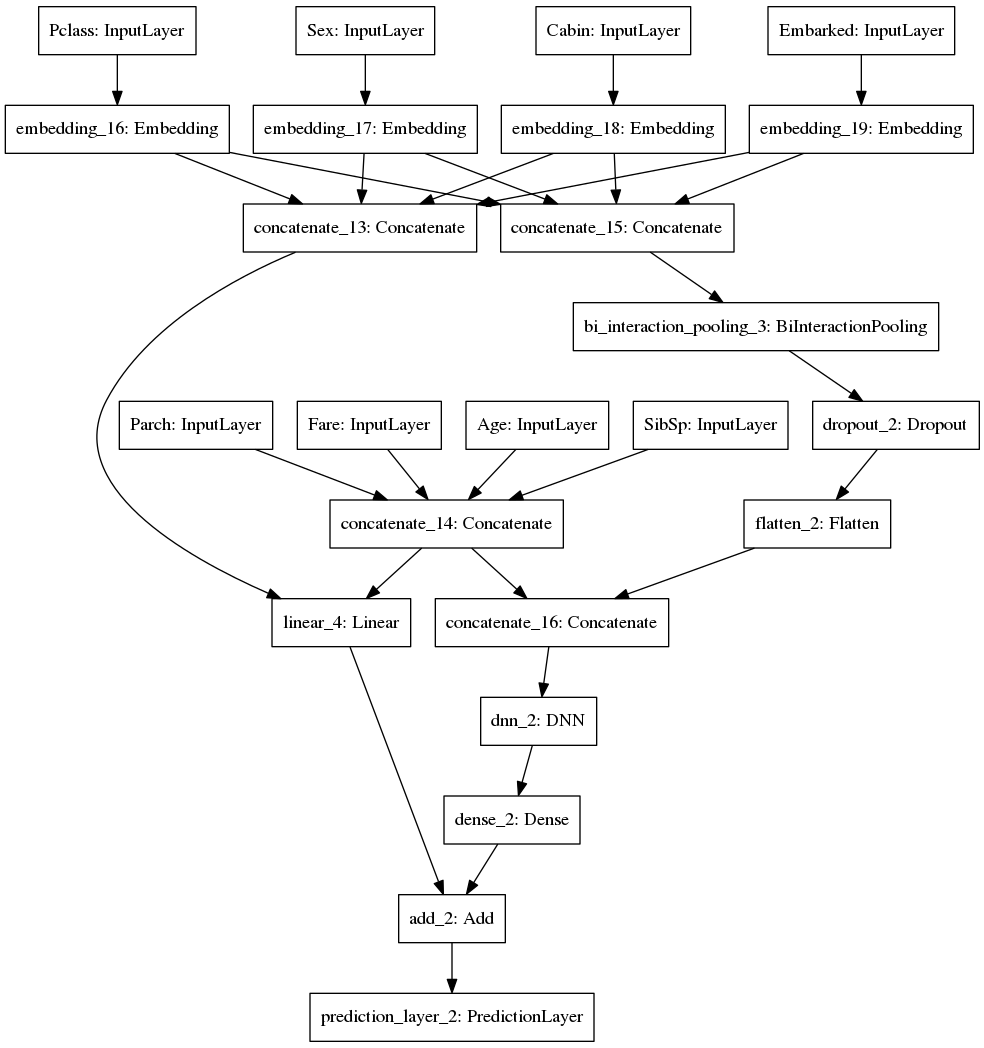

In [58]:
plot_model(nfm_model, to_file='nfm_model.png')

In [59]:
nfm_model.compile(loss='binary_crossentropy', \
        optimizer=Adam(lr=1e-3), \
        metrics=['accuracy'])

history = nfm_model.fit(xtrain_data, ytrain, epochs=5, batch_size=32, validation_data=(xtest_data, ytest))

Train on 712 samples, validate on 179 samples
Epoch 1/5
712/712 [==============================] - 2s 2ms/sample - loss: 1.5540 - accuracy: 0.6756 - val_loss: 0.8308 - val_accuracy: 0.6425
Epoch 2/5
712/712 [==============================] - 0s 141us/sample - loss: 0.9063 - accuracy: 0.7374 - val_loss: 0.8240 - val_accuracy: 0.7207
Epoch 3/5
712/712 [==============================] - 0s 138us/sample - loss: 0.8161 - accuracy: 0.7612 - val_loss: 0.9330 - val_accuracy: 0.6983
Epoch 4/5
712/712 [==============================] - 0s 139us/sample - loss: 0.7586 - accuracy: 0.7640 - val_loss: 0.7087 - val_accuracy: 0.7263
Epoch 5/5
712/712 [==============================] - 0s 145us/sample - loss: 0.6637 - accuracy: 0.7992 - val_loss: 0.6887 - val_accuracy: 0.7542


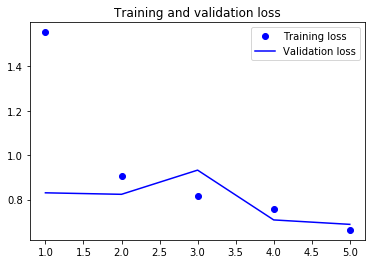

None


In [60]:
import matplotlib.pyplot as plt
 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
print(plt.show())